### To Do:
- Write new library / class file  with recalculated indicators
- Find FED News / plan API and/or take a look at market sentiment API's and backtest
- Come up with an investing plan
- Astrology cycles?
- Small issue with times being local and not UTC. Going to affect daily and weekly charts. Affects Fear and Greed Plot.
- Use pd.tseries.frequencies functions to resample for different time frames e.g. 4H
- Look for correlations btw BTC and M2 supply, interest rates, inflation, etc.
- stock to flow model

### Historic Crypto

- https://www.relataly.com/cryptocurrency-price-charts-with-color-overlay-python/2820/
- https://github.com/David-Woroniuk/Historic_Crypto

- Coinbase Historical Data
    - https://coinmarketcap.com/historical/


In [1]:
""" Packages """
from Historic_Crypto import HistoricalData
from Historic_Crypto import Cryptocurrencies
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt 
import matplotlib.colors as col 
import matplotlib.font_manager as fnt
from mpl_toolkits.axes_grid1 import host_subplot        # Fancier Axes
import mpl_toolkits.axisartist as AA                    # Fancier Axis
from matplotlib import cm
import numpy as np 
import pickle

import datetime as dt
from scipy.stats import pearsonr

### Query, Update, and Store Data

In [109]:
""" Search for Coins"""
data = Cryptocurrencies(coin_search = 'LTC', extended_output=False).find_crypto_pairs()
data

Connected to the CoinBase Pro API.
Found 4 instances containing the term LTC.
Extended Output is False, returning reduced dataset.


,id,display_name,fx_stablecoin,max_slippage_percentage,status
38,LTC-EUR,LTC/EUR,False,0.03000000,online
169,LTC-GBP,LTC/GBP,False,0.03000000,online
205,LTC-USD,LTC/USD,False,0.03000000,online
392,LTC-BTC,LTC/BTC,False,0.03000000,online


In [2]:
"""  Query and Update Coindata """

update_all = True

# the price frequency in seconds granularity: the price data frequency in seconds, one of: 60, 300, 900, 3600, 21600, 86400.
res_dict = {'T':60, '5T': 300, '15T':900, 'H':3600, '6H': 21600, 'D': 86400}

# Defining time string format
time_dict = {
    'T':'%Y-%m-%d-%H-%M',
    '5T':'%Y-%m-%d-%H-%M',
    '15T':'%Y-%m-%d-%H-%M',
    'H':'%Y-%m-%d-%H-00',
    '6H':'%Y-%m-%d-%H-00',
    'D':'%Y-%m-%d-00-00'
}

# Defining Resampling methods
ohlcv_dict = {
 'open': 'first',
 'high': 'max',
 'low': 'min',
 'close': 'last',
 'volume': 'sum'
}

# Read Data
try:
    print(coindata)
except NameError:
    with open('coindata.pickle','rb') as file:
        coindata = pickle.load(file)

# Coins and Resolutions to update:
# Change these if you only want to update specifics
if update_all:
    coin_list = list(coindata.keys())
else:
    res_list = ['W']            
    coin_list = ['LTC-USD'] 

# Update Coindata
for coin in coin_list:
    if update_all:
        res_list = list(coindata[coin].keys())
    for res_ in res_list:       
        if res_ in list(res_dict.keys()):
            resamp = ''
            if coin not in list(coindata.keys()):
                coindata[coin]=dict()
                coindata[coin][res_] = pd.DataFrame()
                from_date = pd.Timestamp('2014-01-01')
            elif res_ not in list(coindata[coin].keys()):
                coindata[coin][res_] = pd.DataFrame()
                from_date = pd.Timestamp('2014-01-01')         
            else:
                from_date = coindata[coin][res_].last_valid_index() + pd.Timedelta(1, res_)     
            end_date = pd.Timestamp.now().floor(res_) + pd.Timedelta(-1, res_) + pd.Timedelta(+1,'T')                #  For utc time and then removing timezone: .utcnow().tz_convert(None)
            res_val = res_dict[res_]
            if from_date > end_date:
                print('The data is up to date')
            else:
                from_date = from_date.strftime(time_dict[res_])
                end_date = end_date.strftime(time_dict['T'])
                newdata = HistoricalData(coin, res_val, from_date, end_date, verbose = False).retrieve_data()
                newdata = newdata[['open','high','low','close','volume']]
                coindata[coin][res_] = pd.concat([coindata[coin][res_], newdata])
        elif res_ not in list(res_dict.keys()):
            # Weekly resample will include incomplete current week data
            if res_ == 'W':                 
                coindata[coin][res_] = coindata[coin]['D'].resample('W-MON',label = 'left', closed='left').agg(ohlcv_dict)

# Write Data
with open('coindata.pickle','wb') as file:
    pickle.dump(coindata, file)

coindata['BTC-USD']['D']

Provisional Start: 2023-04-11T19:00:00
Provisional End: 2023-04-24T07:00:00


/home/alpha/.local/lib/python3.8/site-packages/Historic_Crypto/HistoricalData.py:176: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(dataset)


Provisional Start: 2023-04-24T07:00:00
Provisional End: 2023-05-06T19:00:00
Provisional Start: 2023-04-11T19:00:00
Provisional End: 2023-04-24T07:00:00


/home/alpha/.local/lib/python3.8/site-packages/Historic_Crypto/HistoricalData.py:176: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(dataset)


Provisional Start: 2023-04-24T07:00:00
Provisional End: 2023-05-06T19:00:00
Provisional Start: 2023-04-11T19:00:00
Provisional End: 2023-04-24T07:00:00


/home/alpha/.local/lib/python3.8/site-packages/Historic_Crypto/HistoricalData.py:176: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(dataset)


Provisional Start: 2023-04-24T07:00:00
Provisional End: 2023-05-06T19:00:00


,open,high,low,close,volume
time,,,,,
2015-07-20,277.98,280.00,277.37,280.00,782.883420
2015-07-21,279.96,281.27,276.85,277.32,4943.559434
2015-07-22,277.33,278.54,275.01,277.89,4687.909383
2015-07-23,277.96,279.75,276.28,277.39,5306.919575
2015-07-24,277.23,291.52,276.43,289.12,7362.469083
...,...,...,...,...,...
2023-04-29,29339.47,29470.00,29057.30,29249.35,4909.727178
2023-04-30,29249.24,29969.99,29095.92,29247.14,6837.068314
2023-05-01,29240.49,29348.60,27664.31,28077.27,17953.116700


### Data Visualization

* https://matplotlib.org/stable/gallery/color/colormap_reference.html
* https://stackoverflow.com/questions/44970881/matplotlib-multiple-scatter-subplots-with-shared-colour-bar

#### Price Chart with multiple y-axes

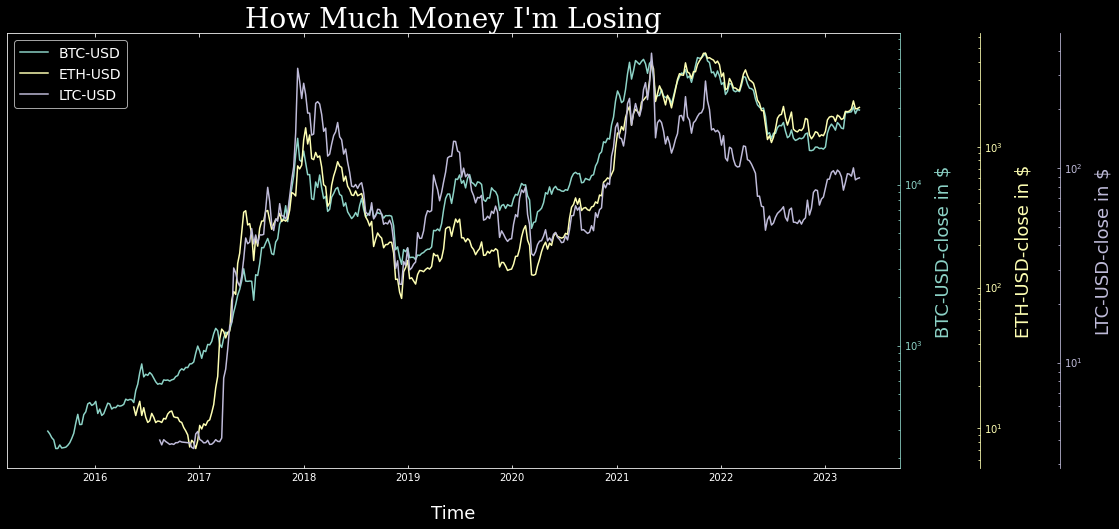

In [3]:
res = 'W'
val = 'close'
coin_list = list(coindata.keys())
coin_list.remove('ADA-USD')
# color_list = ['tab:blue','tab:red','tab:green']

### Define Host Data
# host_data = coindata['BTC-USD']['W']

### Create Figure and Host Axes
# plt.style.use('default')
plt.style.use("dark_background")
fig = plt.figure(figsize=(16, 8))
host = host_subplot(111,figure = fig, axes_class = AA.Axes)                    

# margins inside axis for graphs 
host.margins(x = 0.05) 

# Labels
host.set_yticklabels([])
host.set_yticks([])
host.set_xlabel('Time')                
host.axis['bottom'].label.set_fontsize(18)
# host.set_ylabel('What y-label should go here?',labelpad=48)          
host.axis['left'].label.set_fontsize(22)
host.set_title('How Much Money I\'m Losing', fontsize = 28, fontname = 'DejaVu Serif')  # Fonts: ./home/alpha/.local/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/

fig.set_label('Fig infty')

host_bot = host.axis['bottom']
host_bot.LABELPAD = 24
host.axis['left'].LABELPAD = 24

# Plot Values for Host if desired:


# Price Chart for other values
for i, coin in enumerate(coin_list,0):
    ax_new = host.twinx()
    x = coindata[coin][res].index
    y = coindata[coin][res][val]
    g, = ax_new.plot(x, y,  label = coin_list[i])
    ax_new.set_yscale('log')
    if coin == 'ADA-USD':
        ax_new.set_yscale('linear')
    ax_new.set_ylabel(coin_list[i]+'-'+val+' in $',color = g.get_color(),  fontsize=18)
    ax_right = ax_new.axis['right']
    ax_right.toggle(all = True)

    shift = 80
    new_fixed_axis = ax_new.get_grid_helper().new_fixed_axis
    ax_right = new_fixed_axis(loc="right", axes=ax_new, offset=(shift*i, 0))
    ax_right.label.set_fontsize(18)
    ax_right.line.set_color(g.get_color())
    ax_right.major_ticks.set_color(g.get_color())
    ax_right.minor_ticks.set_color(g.get_color())
    ax_right.major_ticklabels.set_color(g.get_color())
    ax_right.minor_ticklabels.set_color(g.get_color())
    ax_right.LABELPAD = 12
    ax_new.axis['right'] = ax_right

host.legend(prop={'size': 14})

plt.savefig('coin_chart.jpg',  bbox_inches='tight')
plt.draw()
plt.show()


#### Indicators

Value not specified. Using HLC3


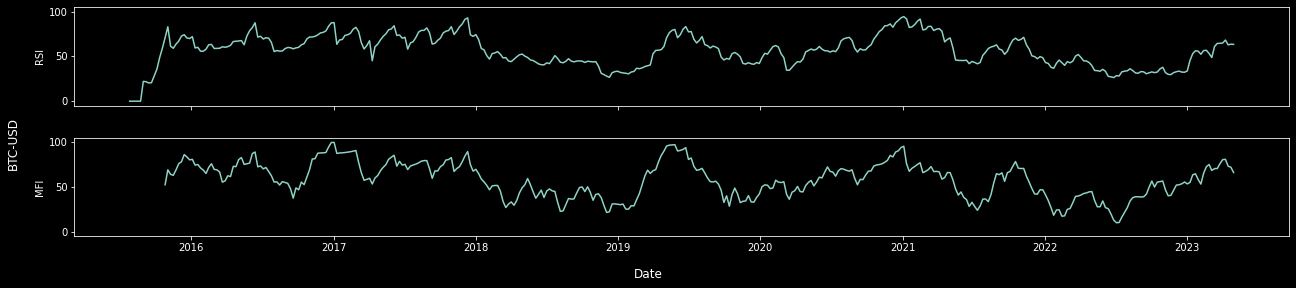

In [4]:
from imp import reload 
import my_ta as ta
try:
    reload(my_ta)
except:
    ()

coin = 'BTC-USD'
res = 'W'
inds = ['RSI', 'MFI']
coin_df = coindata[coin][res].copy()


fig, axs = plt.subplots(2,1,figsize = (18, 4), sharex = True, sharey = True, constrained_layout = True)

# Figure out how to do this with list of indicators
coin_df['RSI'] = ta.rsi(coin_df,14)
coin_df['MFI'] = ta.mfi(coin_df,14)

x = coin_df.index

for i, ax in enumerate(axs):
    y = coin_df[inds[i]]
    ax.plot(x,y, label = inds[i] )  
    ax.set_ylabel(inds[i])
    
fig.supylabel(coin)
fig.supxlabel('Date')
fig.set_constrained_layout_pads(w_pad= 0.1, h_pad = 0.1, hspace=0.2, wspace=0)
plt.show()


##### Colored by RSI / MFI

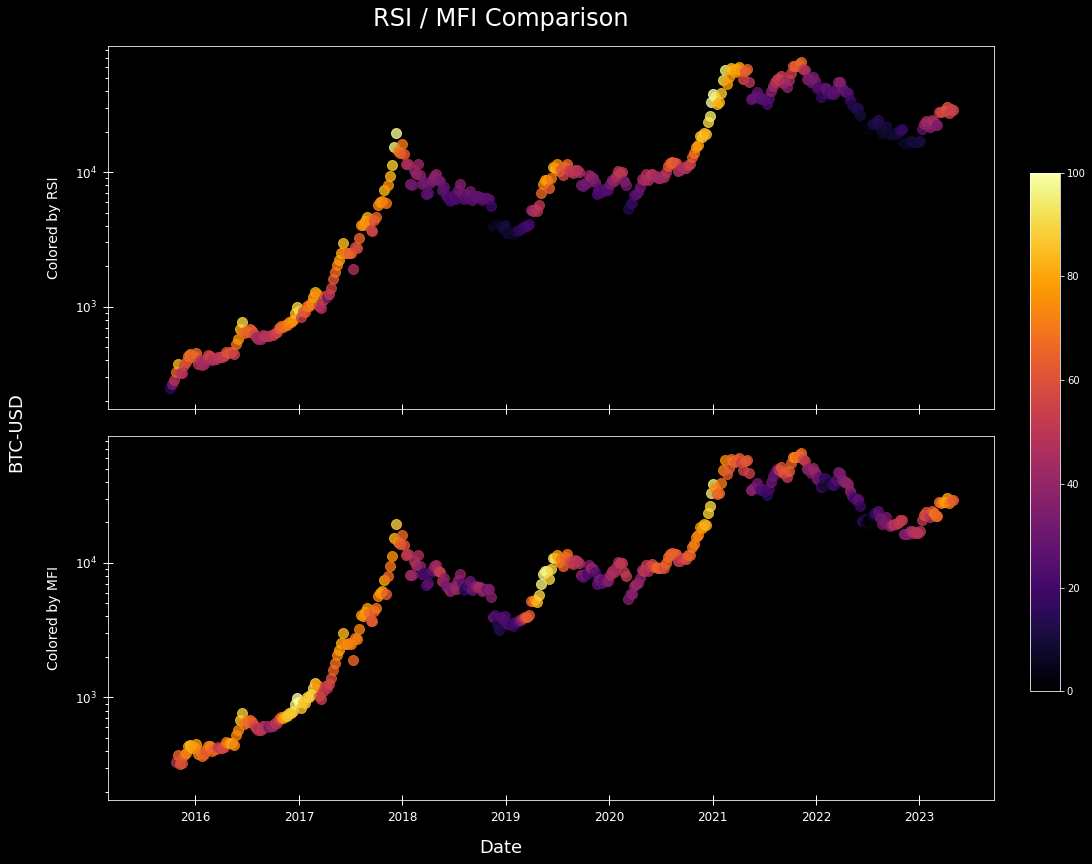

In [5]:
# function that converts a given set of indicator values to colors
def get_colors(ind, colormap, lag):
    colorlist = []
    norm = col.Normalize(vmin=np.nanmin(ind[lag:]), vmax=np.nanmax(ind)) #adjustment made here to ignore the first lagging values
    for i in ind:
        colorlist.append(list(colormap(norm(i))))
    return colorlist

# Color maps
ind_colors = []
colormap = plt.get_cmap('inferno')
lag = 14
for ind in inds:
    vals = np.array(coin_df[ind])
    ind_colors.append(get_colors(vals, colormap, lag))

# Set Canvas 
fig, axs = plt.subplots(2,1, figsize=(14, 12), sharex=True, constrained_layout = True)
fig.set_constrained_layout_pads(w_pad= 0.15, h_pad = 0.1, hspace=0.05, wspace=0)

# Values
x = coin_df.index
y = coin_df['close']

# Plot Values and Coloring
for j in range(len(axs)):
    axes = axs[j]
    axs[j].set_ylabel('Colored by '+inds[j], size = 14, labelpad = 14)
    for i in range(len(x)):
        im = axs[j].semilogy(x[i], np.array(y[i]), 'o',  color=ind_colors[j][i], alpha = 0.8, markersize=10)
    # Tick Parameters
    axes.tick_params('x',
                     direction = 'inout',
                     length = 10.5, 
                     width = 1, 
                    ) 
    axes.tick_params('y',
                     direction = 'inout',
                     length = 10.5, 
                     width = 1,
                     pad = 6, 
                     labelsize = 12, 
                    ) 
    axes.tick_params('y', which = 'minor',
                    #  direction = 'inout',
                     length = 3, 
                     width = 1,
                    ) 
# plot the color bar
pos_neg_clipped = ax.imshow(list(ind_colors[0]), cmap=colormap, vmin=0, vmax=100, interpolation='none') # why does ax.imshow work? What is ax?
cbar_ax = fig.add_axes([1.025, 0.2, 0.03, 0.6])
cb = fig.colorbar(pos_neg_clipped, cax = cbar_ax)

# Sup Figure Labels
fig.supylabel(coin, size = 18)
fig.supxlabel('Date', size = 18)
fig.suptitle('RSI / MFI Comparison', size  =24, )

# Tick Params
top_axes = axs[0]
bot_axes = axs[1]
bot_axes.tick_params('x',
                    #  direction = 'inout',
                    #  length = 10.5, 
                    #  width = 1, 
                     pad = 6, 
                     labelsize = 12,
                    #  grid_alpha = 1,
                     )

plt.show()

##### Fear and Greed Index
* https://alternative.me/crypto/fear-and-greed-index/
* Issue with FG using utc time. BTC Data from query uses local time. Can either change times in query or query data from alternative.me

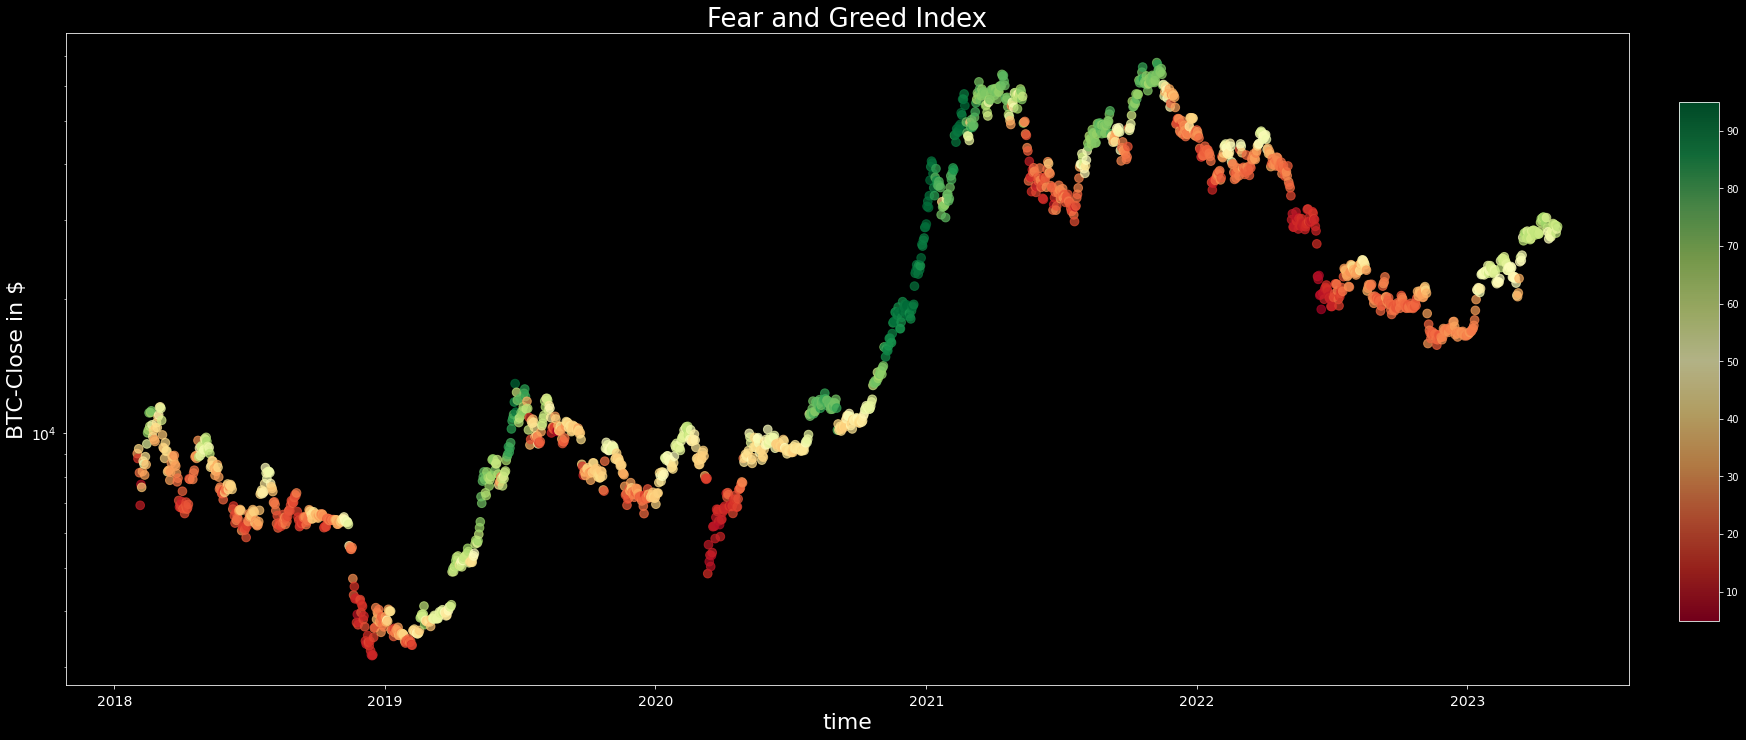

In [6]:
""" Data """
import requests
import json as js

response = requests.get('https://api.alternative.me/fng/?limit=0&date_format=cn')
type(response)

dict = response.json()
time = []
fg_index = []

for i in range(len(dict['data'])):
    time.append(dict['data'][i]['timestamp'])
    fg_index.append(int(dict['data'][i]['value']))

f = {'FG':fg_index}
fg = pd.DataFrame(f, index = pd.to_datetime(time)) 
fg = fg.sort_index()

df = coindata['BTC-USD']['D'][fg.index[0]:].copy()
df = pd.concat([df, fg], axis = 1)#


""" Plotting """
# Canvas
fig, ax = plt.subplots(figsize=(28, 12))
plt.title('Fear and Greed Index', fontsize = 26)
ax.set_xlabel('time', fontsize = 22)
ax.set_ylabel('BTC-Close in $', fontsize=22)
ax.set_yscale('log')

# Values
x = df.index
y = df['close']

# Plot Values and Coloring
im = ax.scatter(x,y, s = 75, alpha = 0.7, c = df['FG'],  cmap = plt.cm.get_cmap('RdYlGn'))

# color bar
cbar_ax = fig.add_axes([0.925, 0.2, 0.02, 0.6])
cb = fig.colorbar(im, cax = cbar_ax)

# Tick Params
ax.tick_params('x',
                #  direction = 'inout',
                #  length = 10.5, 
                #  width = 1, 
                    pad = 6, 
                    labelsize = 14,
                #  grid_alpha = 1,
                    )

ax.tick_params('y',
                #  direction = 'inout',
                #  length = 10.5, 
                #  width = 1, 
                    pad = 6, 
                    labelsize = 14,
                #  grid_alpha = 1,
                    )

plt.show()

#### Logarithmic Fitting
* https://medium.datadriveninvestor.com/using-logarithmic-regression-to-predict-the-future-prices-of-bitcoin-and-ethereum-52f05e7b92b8
* https://www.askpython.com/python/examples/curve-fitting-in-python

RANSAC for non-bubble Data
* https://en.wikipedia.org/wiki/Random_sample_consensus

Object `cycles` not found.


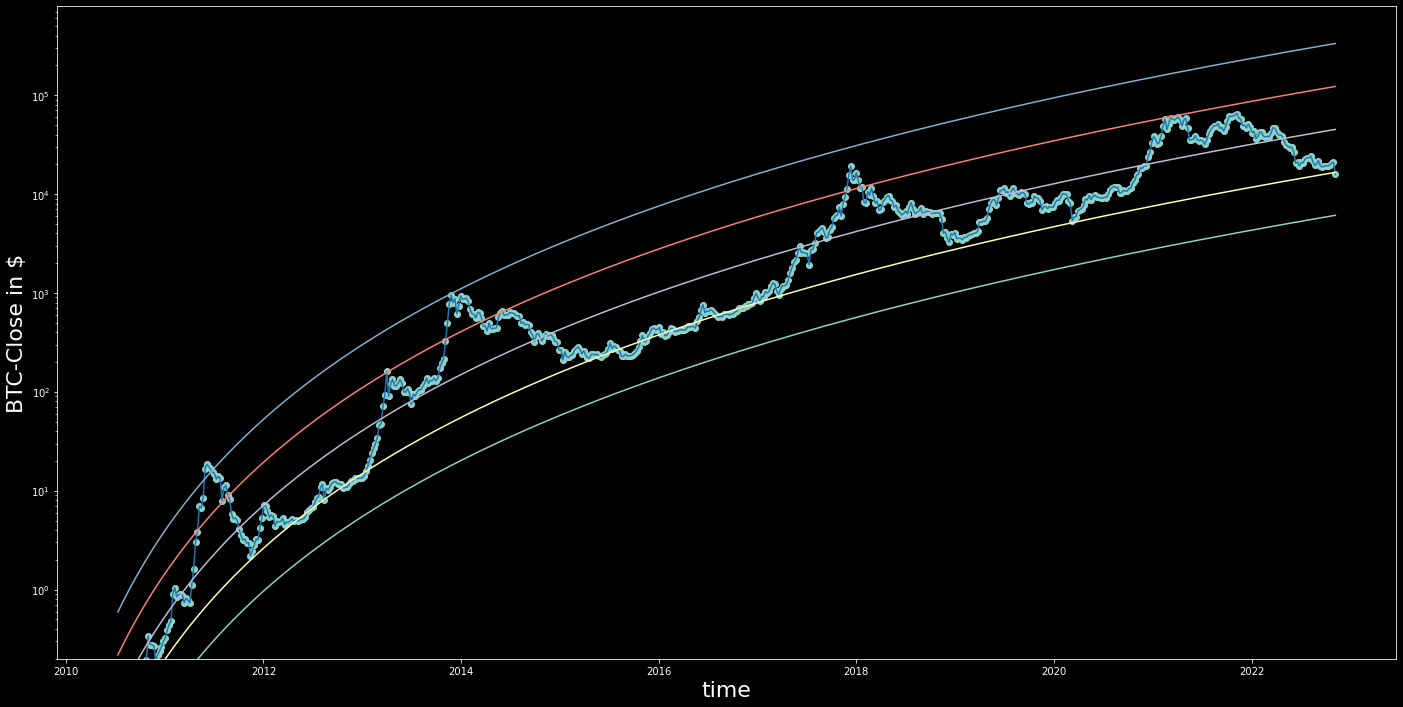

In [8]:
from scipy.optimize import curve_fit

""" functions """
def log_func(x, p1, p2, p3):
    return p1*np.log(x-p2) + p3

def get_furthest_x(y, curve):
    # y is all the log of values 
    # line is the linear regression line
    difference = [abs(y[x] - curve[x]) for x in range(len(curve))]
    max_difference = max(difference)
    return difference.index(max_difference)

def get_non_bubble(xdata, ydata, p):
    iterations = int(p*len(ydata))
    for i in range(0, iterations):  
        # optimal coefficients using curve fit
        popt, pcov = curve_fit(log_func, xdata, ydata,p0=(1.45, -1,1.45))
        fittedY = log_func(np.array([x for x in range(len(ydata))]), popt[0], popt[1], popt[2])

        # Drop Furthest
        outlier = get_furthest_x(ydata, fittedY)      
        ydata = ydata.drop(ydata.index[outlier])
        xdata = [x for x in range(len(ydata))]
    return(ydata)

""" Data Work """
### Initialize Data
with open('coincodex.pickle','rb') as file:
    coincodex = pickle.load(file)
df = coincodex['BTC']['W'].copy()
# df = coindata['BTC-USD']['W'].copy()

ydata = np.log(df['close'])
xdata = [x for x in range(len(df))]

### optimize coefficients
popt, pcov = curve_fit(log_func, xdata, ydata,p0=(1.45, -1,1.45))
fittedYdata = log_func(np.array([x for x in range(len(df))]), popt[0], popt[1], popt[2])

### Non-Bubble Data
p = 0.0
non_bubY = get_non_bubble(xdata, ydata, p)
non_bubX = ydata.index.get_indexer(non_bubY.index)

nbpopt, nbpcov = curve_fit(log_func, non_bubX, non_bubY, p0=(1.0, -1,-1))
nbfittedYdata = log_func(np.array([x for x in range(len(df))]), nbpopt[0], nbpopt[1], nbpopt[2])

""" Plotting """
fig, ax1 = plt.subplots(figsize=(24, 12))
plt.title('BTC logarithmic regression', fontsize = 26)- Astrology cycles?

ax1.set_xlabel('time', fontsize = 22)
ax1.set_ylabel('BTC-Close in $', fontsize=22)

## plot price
color = 'tab:blue'
x = df.index
y=df['close']
ax1.semilogy(x, y, color = color)
ax1.tick_params(axis='y')

## Non-Bubble Data
non_bubY = np.exp(non_bubY)
ax1.scatter(non_bubY.index,non_bubY)

## Log curves
# The non-bubble fitted curve will give the best fit over all non-bubble data. The overall shape of this curve will be used to make 'bands". 
# The lowest band will be adjusted manually to fit 'nice' sections of data

# Primary Band
shift = 0.85
primary_band = nbfittedYdata-shift

# Bands separated by a factor of 10
bands = []
for i in range(-1,4):
    bands.append(primary_band + i)

for i in range(len(bands)):
    y = np.exp(bands[i])    
    ax1.plot(x, y)

plt.ylim(bottom=0.2)
plt.show()


### Pickle Files

In [9]:
# # Write
# with open('coindata.pickle','wb') as file:
#     pickle.dump(coindata, file)

# Read
with open('coindata.pickle','rb') as file:
    coindata = pickle.load(file)
coindata


{'BTC-USD': {'H':                          open      high       low     close      volume
  time                                                                   
  2015-07-20 21:00:00    277.98    278.00    277.92    278.00   59.260456
  2015-07-20 22:00:00    278.00    278.50    277.37    278.14  346.995411
  2015-07-20 23:00:00    278.31    280.00    278.15    280.00  376.627552
  2015-07-21 00:00:00    279.96    281.00    279.38    280.89  288.177976
  2015-07-21 01:00:00    280.89    281.15    280.35    280.36  380.933023
  ...                       ...       ...       ...       ...         ...
  2023-05-04 05:00:00  29111.89  29232.99  29065.09  29215.15  378.678539
  2023-05-04 06:00:00  29215.15  29249.53  29102.22  29176.54  253.732981
  2023-05-04 07:00:00  29176.50  29192.52  29047.15  29074.34  194.561978
  2023-05-04 08:00:00  29075.28  29120.89  28987.62  29100.76  168.079713
  2023-05-04 09:00:00  29098.01  29124.20  29045.65  29102.17  126.508117
  
  [68216 rows x 5 c

### Old Junk

In [27]:
""" Query Data """
# the price frequency in seconds granularity: the price data frequency in seconds, one of: 60, 300, 900, 3600, 21600, 86400.
res_dict = {'T':60, '5T': 300, '15T':900, 'H':3600, '6H': 21600, 'D': 86400}

# Defining time string format
time_dict = {
    'T':'%Y-%m-%d-%H-%M',
    '5T':'%Y-%m-%d-%H-%M',
    '15T':'%Y-%m-%d-%H-%M',
    'H':'%Y-%m-%d-%H-00',
    '6H':'%Y-%m-%d-%H-00',
    'D':'%Y-%m-%d-00-00'
}

# Adjust resolution value
res = 'D'
res_val = res_dict[res]

# Start and stop dates
from_date = '2016-01-01-00-00'

end_date = pd.Timestamp.now().floor(res) + pd.Timedelta(-1, res_) +pd.Timedelta(+1,'T')
end_date = end_date.strftime(time_dict['T'])

# The currency price pairs for which the data will be retrieved
coinlist = ['ADA-USD']

# Initialize coindata file dict of dicts id DNE
if not coindata:
    df = pd.DataFrame()
    for coin in coinlist:
        coindata[coin] = {'H':df, 'D':df, 'W':df}

# Query the data
for coin in coinlist:
    pricedata = HistoricalData(coin, res_val, from_date, end_date, verbose = False).retrieve_data()
    coindata[coin][res] = pricedata[['open','high','low','close','volume']]
coindata


Provisional Start: 2016-01-01T00:00:00
Provisional End: 2016-10-27T00:00:00
CoinBase Pro API did not have available data for 'ADA-USD' beginning at 2016-01-01-00-00.  
                        Trying a later date:'2016-01-01T00:00:00'
Provisional Start: 2016-10-27T00:00:00
Provisional End: 2017-08-23T00:00:00
CoinBase Pro API did not have available data for 'ADA-USD' beginning at 2016-01-01-00-00.  
                        Trying a later date:'2016-10-27T00:00:00'
Provisional Start: 2017-08-23T00:00:00
Provisional End: 2018-06-19T00:00:00
CoinBase Pro API did not have available data for 'ADA-USD' beginning at 2016-01-01-00-00.  
                        Trying a later date:'2017-08-23T00:00:00'
Provisional Start: 2018-06-19T00:00:00
Provisional End: 2019-04-15T00:00:00
CoinBase Pro API did not have available data for 'ADA-USD' beginning at 2016-01-01-00-00.  
                        Trying a later date:'2018-06-19T00:00:00'
Provisional Start: 2019-04-15T00:00:00
Provisional End: 2020-02-

/home/alpha/.local/lib/python3.8/site-packages/Historic_Crypto/HistoricalData.py:176: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(dataset)


Provisional Start: 2021-10-01T00:00:00
Provisional End: 2022-07-28T00:00:00


{'BTC-USD': {'H':                          open      high       low     close       volume
  time                                                                    
  2015-07-20 21:00:00    277.98    278.00    277.92    278.00    59.260456
  2015-07-20 22:00:00    278.00    278.50    277.37    278.14   346.995411
  2015-07-20 23:00:00    278.31    280.00    278.15    280.00   376.627552
  2015-07-21 00:00:00    279.96    281.00    279.38    280.89   288.177976
  2015-07-21 01:00:00    280.89    281.15    280.35    280.36   380.933023
  ...                       ...       ...       ...       ...          ...
  2022-05-17 14:00:00  30482.85  30533.23  29896.90  30028.70  1476.443953
  2022-05-17 15:00:00  30028.64  30197.82  29931.00  30116.20   975.053752
  2022-05-17 16:00:00  30113.56  30199.99  29831.23  30112.94   936.962476
  2022-05-17 17:00:00  30112.94  30228.66  30045.03  30054.53   850.919189
  2022-05-17 18:00:00  30054.53  30212.99  29415.01  29820.67  1617.544371
  
  [597

In [108]:
""" Update Coindata on Res """

with open('coindata.pickle','rb') as file:
    coindata = pickle.load(file)
coinlist = list(coindata.keys())

# resolution dictionary
res_dict = {'T':60, '5T': 300, '15T':900, 'H':3600, '6H': 21600, 'D': 86400}
res_other = ['W','M']

# Defining time string format
time_dict = {
    'T':'%Y-%m-%d-%H-%M',
    '5T':'%Y-%m-%d-%H-%M',
    '15T':'%Y-%m-%d-%H-%M',
    'H':'%Y-%m-%d-%H-00',
    '6H':'%Y-%m-%d-%H-00',
    'D':'%Y-%m-%d-00-00'
}

# Define the resampling logic
ohlcv_dict = {
     'open': 'first',
     'high': 'max',
     'low': 'min',
     'close': 'last',
     'volume': 'sum'
}

# Change this value for the sampling resolution
res = 'W'                               

##  Update on res ##
for coin in list(coindata.keys()):
    for res_ in [res]:
        if res_ in list(res_dict.keys()):
            resamp = ''
            from_date = coindata[coin][res_].last_valid_index() + pd.Timedelta(1, res_)
            if from_date == pd.NaT:
                from_date = pd.Timestamp('2015-01-01')
            end_date = pd.Timestamp.now().floor(res_) + pd.Timedelta(-1, res_) + pd.Timedelta(+1,'T')                                #  For utc time and then removing timezone: .utcnow().tz_convert(None)
            print(from_date)
            print(end_date)
            res_val = res_dict[res_]
            if from_date > end_date:
                print('The data is up to date')
            else:
                from_date = from_date.strftime(time_dict[res_])
                end_date = end_date.strftime(time_dict['T'])
                newdata = HistoricalData(coin, res_val, from_date, end_date).retrieve_data()
                newdata = newdata[['open','high','low','close','volume']]
                coindata[coin][res_] = pd.concat([coindata[coin][res_],newdata])
        if res_ not in list(res_dict.keys()):
            if res_ == 'W':
                coindata[coin][res_] = coindata[coin]['D'].resample('W-MON',label = 'left', closed='left').agg(ohlcv_dict)
coindata        

# if res_ == 'W':
# day = pd.Timestamp.now().floor('D')
# end_date = day - pd.to_timedelta(day.dayofweek+1, unit='d')+ pd.Timedelta(+1,'T') 


{'BTC-USD': {'H':                          open      high       low     close      volume
  time                                                                   
  2015-07-20 21:00:00    277.98    278.00    277.92    278.00   59.260456
  2015-07-20 22:00:00    278.00    278.50    277.37    278.14  346.995411
  2015-07-20 23:00:00    278.31    280.00    278.15    280.00  376.627552
  2015-07-21 00:00:00    279.96    281.00    279.38    280.89  288.177976
  2015-07-21 01:00:00    280.89    281.15    280.35    280.36  380.933023
  ...                       ...       ...       ...       ...         ...
  2022-05-19 04:00:00  29162.31  29250.00  29037.80  29051.07  597.635124
  2022-05-19 05:00:00  29052.70  29170.21  28994.03  29031.50  567.618670
  2022-05-19 06:00:00  29029.36  29393.58  29026.46  29282.14  846.989909
  2022-05-19 07:00:00  29282.14  29317.30  29043.32  29162.59  930.581323
  2022-05-19 08:00:00  29161.55  29228.32  28924.38  28928.10  821.607785
  
  [59826 rows x 5 c